In [1]:
# LIBRERIAS
import matplotlib
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
import celluloid as cell  #animations
import pandas as pd
import os
from scipy.interpolate import CubicSpline
import math


#sns.set_theme()
#matplotlib.rc('xtick', labels
# ize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

path=os.getcwd()



def fourierT(f):

    return (np.fft.fftshift(np.fft.fft(np.fft.fftshift(f))))


def fourierI(f):

    return (np.fft.fftshift(np.fft.ifft(np.fft.fftshift(f))))



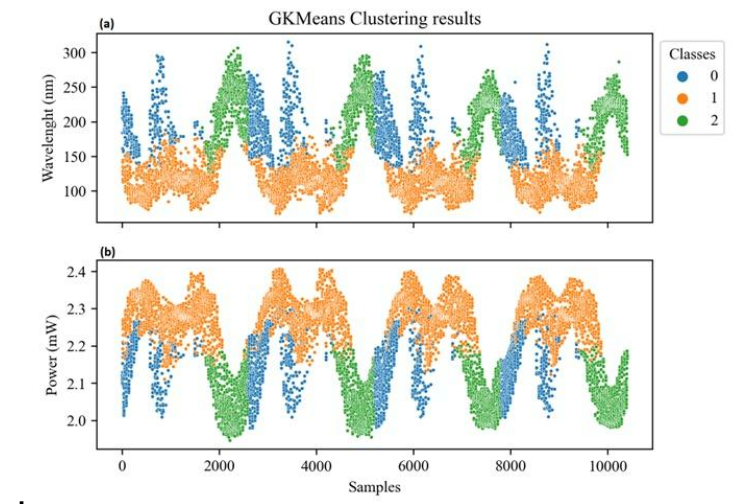

# Resultados obtenidos en el laboratorio.

In [2]:
def new_methodc(I1,I2,phi1,phi2,gamma,S,C,B,T,dt,h,cond=1):
    '''
    Este codigo calcula un paso espacial. Recibe un array
    con la intensidad y la fase. Modifica ese array para dar lugar al
    siguiente paso espacial.

    '''

    I1n_j = I1  # Recibe In_j
    phi1n_j = phi1  # Recibe phin_j
    I2n_j = I2  # Recibe In_j
    phi2n_j = phi2  # Recibe phin_j

    I1new = []
    phi1new = []
    I2new = []
    phi2new = []

    # Ciclo para calcular cada componente del array que contendra el siguiente
    # paso espacial
    for j in range(0,len(I1n_j)):

        I1tn_j = (I1n_j[j]+I1n_j[j-1])*0.5
        deltaI1n_j = I1n_j[j]-I1n_j[j-1]
        deltatheta1 = phi1n_j[j]-phi1n_j[j-1]
        deltatau1n_j = min([abs(deltatheta1),abs(deltatheta1+2*np.pi),abs(deltatheta1-2*np.pi)])

        I2tn_j = (I2n_j[j]+I2n_j[j-1])*0.5
        deltaI2n_j = I2n_j[j]-I2n_j[j-1]
        deltatheta2 = phi2n_j[j]-phi2n_j[j-1]
        deltatau2n_j = min([abs(deltatheta2),abs(deltatheta2+2*np.pi),abs(deltatheta2-2*np.pi)])

 
        if cond==1:
           


            if abs(deltatheta1) == deltatau1n_j:
                deltaphi1n_j = deltatheta1
            elif  abs(deltatheta1+2*np.pi) == deltatau1n_j:
                deltaphi1n_j = deltatheta1 + 2*np.pi
            else:
                deltaphi1n_j = deltatheta1 - 2*np.pi
                
            I1n1_j = I1n_j[j]-h/dt*gamma*S*((3*I1tn_j+B*I2tn_j)*deltaI1n_j
                                            +2*B*I1tn_j*deltaI2n_j)
            
            phi1tn1_j = phi1n_j[j]-h/dt*gamma*(T*(deltaI1n_j+B*deltaI2n_j)
                                    +S*(I1tn_j+B*I2tn_j)*deltaphi1n_j)
        
            phi1n1_j = phi1tn1_j + h*gamma*(I1n1_j+C*I2n_j[j])

            I1new.append(I1n1_j) # Intensidad en el siguiente paso espacial
            phi1new.append(phi1n1_j) #vfase en el siguiente paso espacial

        else:
            if abs(deltatheta2) == deltatau2n_j:
                deltaphi2n_j = deltatheta2
            elif  abs(deltatheta2+2*np.pi) == deltatau2n_j:
                deltaphi2n_j = deltatheta2 + 2*np.pi
            else:
                deltaphi2n_j = deltatheta2 - 2*np.pi
                

            I2n1_j = I2n_j[j]-h/dt*gamma*S*((3*I2tn_j+B*I1tn_j)*deltaI2n_j
                                            +2*B*I2tn_j*deltaI1n_j)
            phi2tn1_j = phi2n_j[j]-h/dt*gamma*(T*(deltaI2n_j+B*deltaI1n_j)
                                    +S*(I2tn_j+B*I1tn_j)*deltaphi2n_j
                                    )
            phi2n1_j = phi2tn1_j + h*gamma*(I2n1_j+C*I1n_j[j])

       
            I2new.append(I2n1_j) # Intensidad en el siguiente paso espacial
            phi2new.append(phi2n1_j) #vfase en el siguiente paso espacial

      
        # I2n_j = I2n1_j
        # phi2n_j = phi2n1_j
    if cond == 1:
        return np.sqrt(np.array(I1new))*np.exp(1j*np.array(phi1new))
    else:

        return np.sqrt(np.array(I2new))*np.exp(1j*np.array(phi2new))
    


def fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,lenght,dt,steps):

    
    h = lenght/steps
  
    betas_freq1 = sum((1j)**(i+1)*betas1[i]*(1j*V)**(i+2)/math.factorial(i+2) for i in range(0,len(betas1)))
    betas_freq2 = sum((1j)**(i+1)*betas2[i]*(1j*V)**(i+2)/math.factorial(i+2) for i in range(0,len(betas2)))
    
    UD1 = np.exp(-h*0.5*betas_freq1,dtype=complex)
    UD2 = np.exp(-h*0.5*(betas_freq2+1j*delta*V),dtype=complex)



    for i in range(steps):
        
        stability1 = (h/dt*gammas[0]*S[0]*np.amax(3*np.abs(A1)**2+B[0]*np.abs(A2)**2))
        stability2 = (h/dt*gammas[1]*S[1]*np.amax(3*np.abs(A1)**2+B[1]*np.abs(A2)**2))

        # if stability1 < 1 and stability2 < 2:
        #     print(True)

        A1a = fourierI(UD1*fourierT(A1))
        A2a = fourierI(UD2*fourierT(A2))
        I1 = np.abs(A1a)**2
        phi1 = np.angle(A1a)
        I2 = np.abs(A2a)**2
        phi2 = np.angle(A2a)
        

        A1as = new_methodc(I1,I2,phi1,phi2,gammas[0],S[0],C[0],B[0],T,dt,h/2)

        I1as = np.abs(A1as)**2
        phi1as = np.angle(A1as)

        A2aa = new_methodc(I1as,I2,phi1as,phi2,gammas[1],S[1],C[1],B[1],T,dt,h,cond=2)

        I2aa = np.abs(A2aa)**2
        phi2aa = np.angle(A2aa)
        
        A1aa = new_methodc(I1as,I2aa,phi1as,phi2aa,gammas[0],S[0],C[0],B[0],T,dt,h/2)
        
        A1 = fourierI(UD1*fourierT(A1aa))
        A2 = fourierI(UD2*fourierT(A2aa))

    return A1,A2

def Delta_landa1(y_data,x_data):

    
    cs=CubicSpline(x_data,y_data)
    new_xdata=np.linspace(min(x_data),max(x_data),len(x_data)*3)
    Y=cs(new_xdata)
    medium_value=np.max(Y)*0.01
    M_V=[]
    wl_s=[]
    pow_s=[]
    
    for i in range(len(Y)):
        if Y[i]>medium_value:
            
            M_V.append(i)
            wl_s.append(new_xdata[i])
            pow_s.append(Y[i])
            

    x1=new_xdata[np.min(M_V)]; 
    x2=new_xdata[np.max(M_V)]
    return abs(x2-x1)



def stokes_params(A1,A2,phi):

    A1_max  = np.amax(np.abs(A1))
    A2_max  = np.amax(np.abs(A2))
    S0 = A1_max**2+A2_max**2
    S1 = A1_max**2-A2_max**2
    S2 = 2*A1_max*A2_max*np.cos(phi)
    S3 = 2*A1_max*A2_max*np.sin(phi)


# Simulación laboratorio.

In [3]:
frep=37.5*1e6  # Tasa de repetición.
tau1=300e-15 ; tau2=200e-15 # Rango ancho temporal pulso.
WaveLength=1550e-9      #reference wavelength [m]
c = 299792458
w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
length = 2.0             #ibre length [m]
D=-1.0*1e-12*1e9*1e-3 #Dispersion
dD=0.006*1e-12*1e9**2*1e-3  #Dispersion slope
#betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
beta2=-WaveLength**2/(2*np.pi*c)*D
P0=130e-3 # Potencia media.
gamma=10.8*1e-3 # Coeficiente de nolinealidad fibra
Ppeak=P0/(frep*tau1)
Ld=tau1**2/beta2
Lnl=1/(Ppeak*gamma)
P0=130e-3 # Potencia media.
gamma=10.8*1e-3
Ppeak=P0/(frep*tau2)
Ld1=tau2**2/beta2
Ppeak2=P0/(frep*tau2)
Lnl1=1/(Ppeak2*gamma)

In [4]:
print('Ld, con 300 fs:',Ld)
print('Lnl, con 300 fs:',Lnl)
print('Ld, con 200 fs:',Ld1)
print('Lnl, con 200 fs:',Lnl1)

Ld, con 300 fs: 70.56343020095599
Lnl, con 300 fs: 0.008012820512820512
Ld, con 200 fs: 31.361524533758224
Lnl, con 200 fs: 0.005341880341880342


[1.14867626e+15 1.15614682e+15 1.16118141e+15 1.16594133e+15
 1.17041926e+15 1.17460825e+15 1.18176603e+15 1.18735707e+15
 1.19333496e+15 1.19634653e+15 1.19971059e+15 1.20207672e+15
 1.20377253e+15 1.20581383e+15 1.20854636e+15 1.21335821e+15
 1.21786079e+15 1.21960146e+15 1.22169684e+15 1.22379944e+15
 1.22626164e+15 1.23086067e+15 1.23228271e+15 1.23370803e+15
 1.23477919e+15 1.23621030e+15 1.23872274e+15 1.24052360e+15
 1.24269156e+15 1.24559399e+15 1.25217428e+15 1.25771119e+15
 1.26254962e+15 1.26667284e+15 1.27082308e+15 1.27690858e+15
 1.28847740e+15 1.29867462e+15]


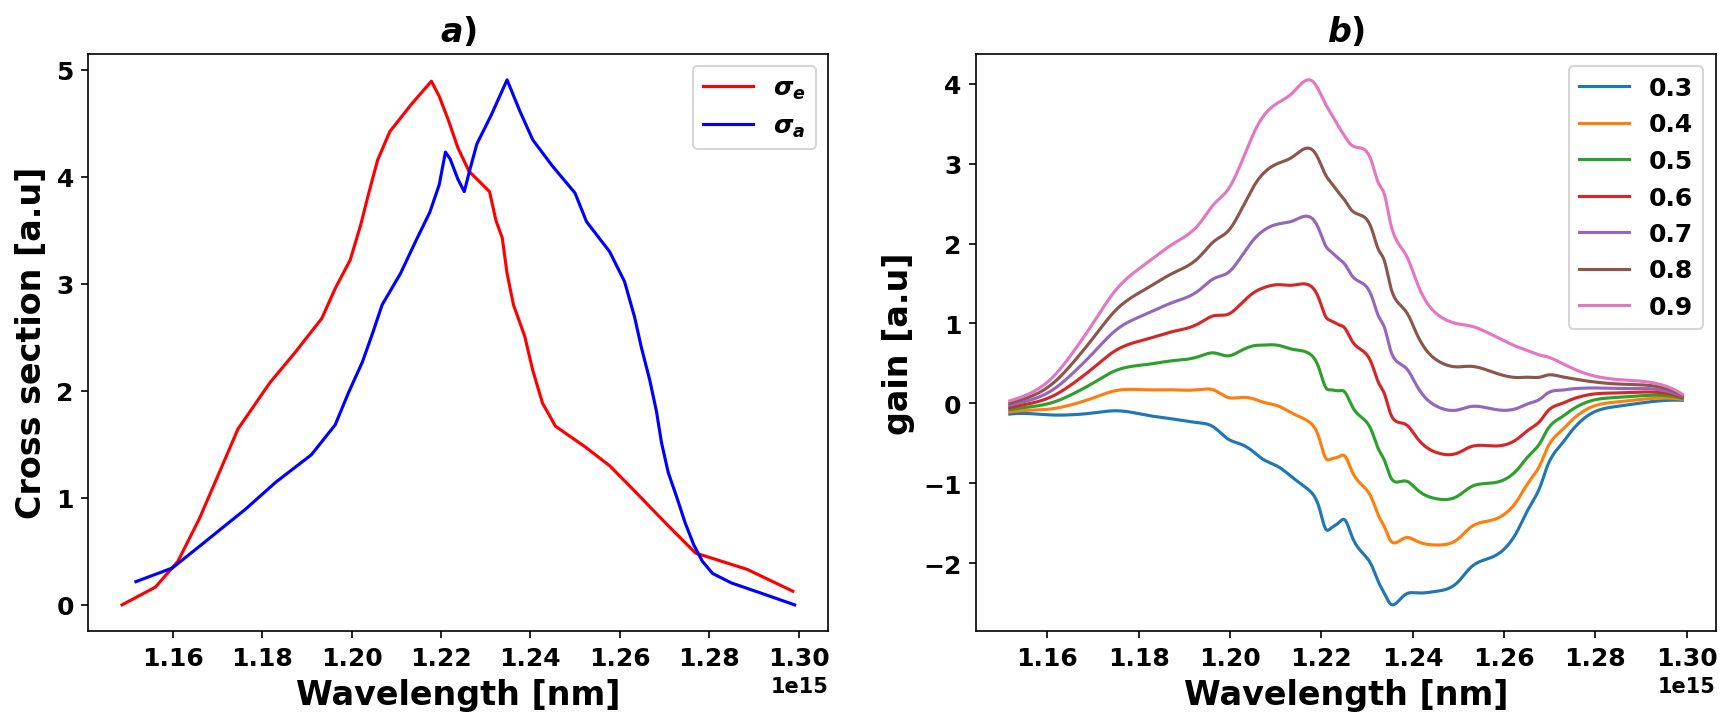

In [5]:
n = 2**12    # number of grid points
TimeWindow = 5*1e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-TimeWindow,TimeWindow,dT) #  time grid
dw=np.pi/(n*dT)
V=np.array([j*dw for j in range(-int(n),int(n))])
# Load emission and absorcion cross-section
emis=np.loadtxt('Emision.txt',delimiter=';')
ab=np.loadtxt('Absorcion.txt',delimiter=';')
emis_y = emis[:,1]
emis_x = np.sort((2*np.pi*c/(emis[:,0]*1e-9))) #np.linspace(1400,1650,len(emis_y))
we = emis_x
midwe = (max(we)+min(we))/2
we = we-midwe
abs_y = ab[:,1]
abs_x = np.sort((2*np.pi*c/(ab[:,0]*1e-9))) #np.linspace(1400,1650,len(emis_y))
wa = np.sort(abs_x)
midwa = (max(wa)+min(wa))/2
wa = wa-midwa
print(emis_x)
cse1 = CubicSpline(emis_x,emis_y)
emis_xdata = np.linspace(min(abs_x),max(emis_x),n*2)
Y_emis = cse1(emis_xdata)
cse = CubicSpline(we,emis_y)
csa = CubicSpline(wa,abs_y)
csa1 =  CubicSpline(abs_x,abs_y)
abs_xdata=np.linspace(min(abs_x),max(abs_x),n*2)
Y_abs=csa1(abs_xdata)


def gg1(G):

  return ((G)*cse1(emis_xdata)-(1-G)*csa1(abs_xdata))



f=plt.figure(figsize=(14,5),dpi=150)


plt.subplot(121)
plt.plot(emis_x,emis_y,'r',label='$\sigma_e$')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(abs_x,abs_y,'b',label='$\sigma_a$')
plt.title('$a)$',fontsize=16,fontweight='bold')
plt.xlabel('Wavelength [nm]',fontsize=16,fontweight='bold')
plt.ylabel('Cross section [a.u]',fontsize=16,fontweight='bold')
plt.legend(fontsize=12)


D= np.arange(0.3,1,0.1)
plt.subplot(122)

for i in D:
    
    plt.plot(abs_xdata,gg1(i),label=str(round(i,3)))
       
plt.xlabel('Wavelength [nm]',fontsize=16,fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('gain [a.u]',fontsize=16,fontweight='bold')
plt.title('$b)$',fontsize=16,fontweight='bold')
plt.legend(fontsize=12)


In [144]:
def anim2(Pp,Pavg):
    N = 10e25
    Psat_p = 113e-6
    Pa_p = 136e-6
    Pe_p = 679e-6
    A = 5.3*(1e-12)
    tau = 10e-3
    hbar = 1.054e-34 # m^2 g/s
    omega = np.sort(2*np.pi*c/(abs_xdata))
    Psat = hbar*omega*A/((cse1(omega)+csa1(omega))*tau)
    g = N*(1e-25*cse1(abs_xdata)*Pp/Pa_p-1e-25*csa1(abs_xdata)*(Pp/Pe_p+1))/(1+Pp/Psat_p+Pavg/Psat)
   
    plt.plot(omega,g,'k')
  
   

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,         
        Pp= widgets.FloatSlider(min=0,max=100,value=100e-3,step=1e-3,**opc),
        Pavg= widgets.FloatSlider(min=1e-3,max=100,value=10e-3,step=1e-3,**opc)    
        #mm
        );

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='Pp', readout_format='.3f', …

# Simulación del EDFA

In [130]:
def erbium_fiber(u0,dt,dz2,nz2,PL,Tr,loss,D2,gamma2,G,GG):
    '''
    Propagates an initial field through erbium doper fiber

    Parameters 
    ----------
    u0: array_like
        initial field
    dt: float
        time resolution
    dz2: float
        spatial resolution
    nz2: float
        Number of points along progation distance
    PL: float
        Saturation power Erbium
    Tr: float
        Round trip
    loss: float
        linear fiber loss
    D2: float
        Fiber dispersion (beta2)
    gamma2: float
        nonlinear parameter
    G: float
        Related to pump power [0,1]
    GG: float
        'Amplitude of gain'
    '''

    nt = len(u0)
    luz = 299792458
    L = nt*dt
    t = np.linspace(-L/2,L/2,nt)
    dw = 2*np.pi/(nt*dt)
    V = np.array([j*dw for j in range(-int(nt/2), int(nt/2))]) # Frequency THz
    V = np.fft.fftshift(V)


    def gg(omega,G):
        
        return ((G)*cse(omega)-(1-G)*csa(omega))


    gain = gg(V,G)*GG
    
    gahno = gain*np.exp(-np.trapz(np.abs(u0)**2,t)/(PL*Tr))
    
    halfstep1=-loss+gahno-1j*D2/2*(1j*V)**2
   
    halfstep=np.exp(halfstep1*dz2/2)

    u1=u0

    # field propagation through fiber.
    for iz in range(1,nz2):

        ufft1= np.fft.fft(u1)
        uhalf1=np.fft.ifft(halfstep*ufft1)
        as1=(np.abs(u1)**2)
        uv1=uhalf1*np.exp((1j*gamma2*as1)*dz2) 
        uv1=np.fft.fft(uv1)
        ufft1=halfstep*uv1
        uv1=np.fft.ifft(ufft1)
        u1=uv1

    return u1

In [184]:
z2 = 0.3 # Erbium lenght
nz2 = 100 # Number of steps along fiber
dz2 = z2/nz2
n = 1.5 # Refractive index
Tr = ((((z2)*n)/luz))*1e12  # Round trip time
loss = 0 # Fiber loss
N = [0,1] #;N
GG = 4
PL = 0.64*1e-3#0.538*1e-3 # Saturatin power
D21 = -22.75  #; % parametro de dispersão (GVD)
wl = 1550
D2 = -(D21*wl**2/(2*np.pi*c))*1e-24  #% beta2 (ps^2/m)
gamma2 = 4.6*1e-3 # Nonlinear parameter

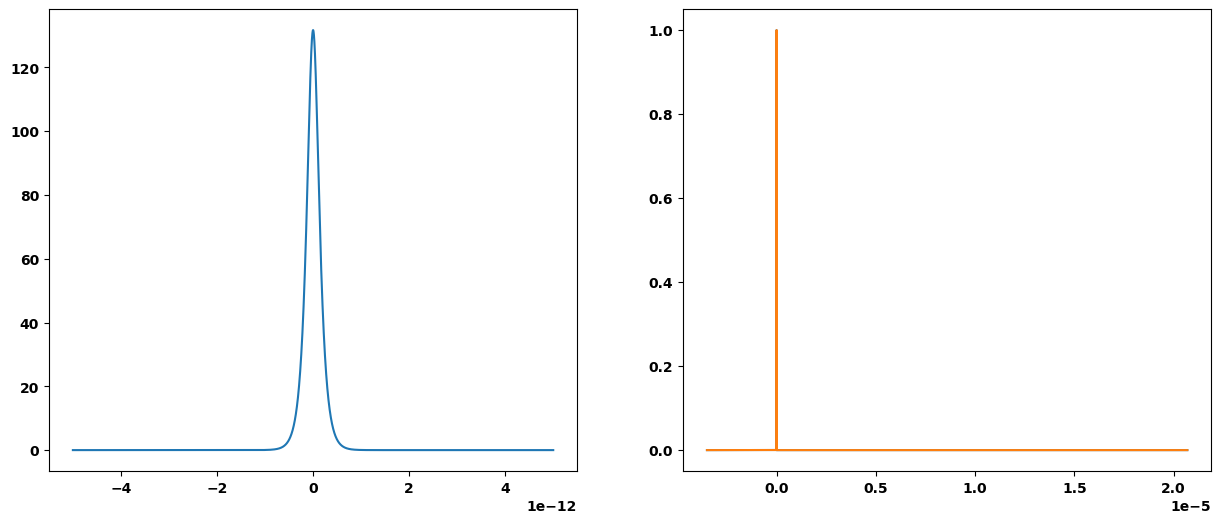

In [190]:
tau1 = 300e-15

f = plt.figure(figsize = (15,6))


plt.subplot(121)
A = np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1)  #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
plt.plot(TimeGrid,A)

plt.subplot(122)
y = erbium_fiber(A/max(A),dt,dz2,nz2,PL,Tr,loss,D2,gamma2,N[1],GG)
w=(V+w0)*1e12
WL=np.sort((2*np.pi*luz)/w)


yif = np.abs(fourierT(A))**2
yf = np.abs(fourierT(y))**2
plt.plot(WL*1e9,yf/max(yf))
plt.plot(WL*1e9,yif/max(yif))

In [65]:
def ruido(señal,desv): 
    '''
    Función para añadir ruido Gaussiano dada una desviación estandar

    Parametros
    ----------
    señal: Arreglo
      Arreglo con la señal a la que se le va añadir el ruido
    desv: float
      Desviación estandar
    '''
    señal_ruido=[np.random.normal(señal[i], abs(señal[i]*desv)) for i in range(0,len(señal))]
    return np.array(señal_ruido)

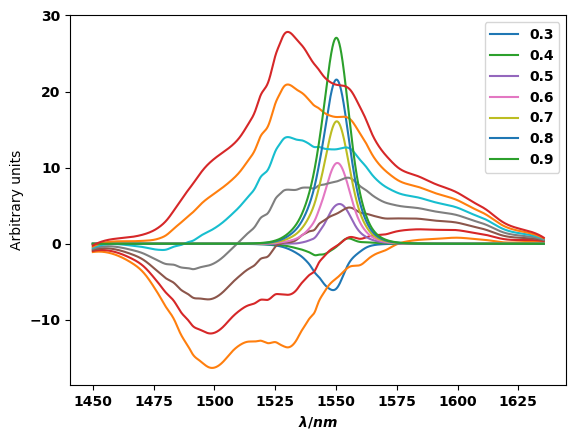

In [76]:
WL_central=1550
WL_in=abs_xdata
a=1
c=0.3
b=5
l=1
p=5
pulse=a*np.cosh((WL_in-WL_central)/b)**-1+c*np.cosh((WL_in-(WL_central+l))/p)**-1
y = ruido(pulse,0)
#plt.plot(dfA['Stop'][:],dfA['1749.9'][:]/max(dfA['1749.9'][:]),'k',label='Real+noise')
for i in D:
    
    plt.plot(WL_in,gg1(i)*y,label=str(round(i,3)))
    plt.plot(WL_in,gg1(i))

plt.xlabel('$\lambda /nm$')
plt.ylabel('Arbitrary units')
plt.legend()

# Simulación supercontinuo parametros actuales

In [110]:
def anim2(k,t,tau,BB):
    
    wl = 1550e-9      #reference wavelength [m]
    c = 299792458
    n = 2**12    # number of grid points
    TimeWindow = 12*1e-12 # width of time window [s]     
    dT = TimeWindow/n
    TimeGrid =  np.arange(-TimeWindow,TimeWindow,dT) #  time grid
    w0 = (2*np.pi*c)/wl  #reference frequency [Hz]
    length = 2.0             #ibre length [m]
    D = -1e-12*1e9*1e-3 #Dispersion
    dD = 0.006*1e-12*1e9**2*1e-3  #Dispersion slope
    beta2=-wl**2/(2*np.pi*c)*D
    beta3=(wl**2/(2*np.pi*c))**2*(2*D/wl+dD)
    betas1=[beta2,beta3]
    betas2 = [beta2,beta3]
    P0 = 10e-3 # Potencia media.
    gamma = 10.8*1e-3 # Coeficiente de nolinealidad fibra
    tau1 = 300e-15
    frep = 37.5*1e6  # Tasa de repetición.
    Ppeak = P0/(frep*tau1)
    T = t*1e-15
    gammas = [gamma,gamma]
    B = [0,0]
    C = [BB,BB]
    c = 299792458;   
    wl1 = 1550e-9
    w01 = (2*np.pi*c)/wl1  #reference frequency [Hz]
    wl2 = 1550e-9
    w02 = (2*np.pi*c)/wl2  #reference frequency [Hz]
    S = [1/w01,1/w01]        
    delta = 0
    steps = 50
    tau1 = tau*1e-15
    A1 = np.cos(k)*np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1)  #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
    A2 = np.sin(k)*np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1) #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
    dw = np.pi/(n*dT)
    V = np.array([j*dw for j in range(-int(n),int(n))])
    W = V+w0
    WL = ((2*np.pi*c/W)) #iis = (WL>400 & WL<1350); % wavelength grid
    y1,y2 = fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,length,dT,steps)

    f = plt.figure(figsize = (15,6))

    plt.subplot(121)

    yf = fourierT(y1+y2)
    y = np.abs(yf/np.amax(yf))**2
    plt.plot(WL*1e9,y, label = 'Propagated spectrum')
    plt.plot(WL*1e9,np.abs(fourierT(A1+A2))**2/np.amax(np.abs(fourierT(A1+A2))**2), label = 'Initial spectrum')
    plt.xlim(1400,1800)
    plt.xlabel('$\lambda$ $[nm]$')
    plt.legend()

    ylog = 10*np.log10(y)
    yin = fourierT(A1+A2)/np.amax(fourierT(A1+A2))
    ylog_in = 10*np.log10(np.abs(yin)**2)
    
    plt.subplot(122)
    plt.plot(WL*1e9,ylog,'r',label ='Propagated spectrum')
    plt.plot(WL*1e9,ylog_in,'--k',label = 'Initial spectrum')
    plt.xlabel('$\lambda$ $[nm]$')
    plt.legend()
    plt.xlim(1300,1800)
    plt.ylim(-60,10)
    print(Delta_landa1(y,np.sort((2*np.pi*c/W))*1e9))

    f = plt.figure(figsize = (15,6))
    plt.plot(A1,A2)
    plt.xlabel('AX')
    plt.ylabel('AY')
    print(A2)
  
   

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,         
        k= widgets.FloatSlider(min=0,max=2*np.pi,value=0,step=0.001,**opc),
        t = widgets.FloatSlider(min=0.3,max=3,value=2,step=0.1,**opc),
        tau = widgets.FloatSlider(min=100,max=800,value=300,step=1,**opc),
        BB = widgets.FloatSlider(min=0,max=2,value=2/3,step=0.1,**opc)
     
        
        #mm
        );

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='k', max=6.283185307179586, …

In [7]:
wl = 1550e-9      #reference wavelength [m]
c = 299792458
n = 2**12    # number of grid points
TimeWindow = 12*1e-12 # width of time window [s]     
dT = TimeWindow/n
TimeGrid =  np.arange(-TimeWindow,TimeWindow,dT) #  time grid
w0 = (2*np.pi*c)/wl  #reference frequency [Hz]
length = 2.0             #ibre length [m]
D = -1e-12*1e9*1e-3 #Dispersion
dD = 0.006*1e-12*1e9**2*1e-3  #Dispersion slope
beta2=-wl**2/(2*np.pi*c)*D
beta3=(wl**2/(2*np.pi*c))**2*(2*D/wl+dD)
betas1=[beta2,beta3]
betas2 = [beta2,beta3]
P0=10e-3 # Potencia media.
gamma = 10.8*1e-3 # Coeficiente de nolinealidad fibra
tau1 = 320e-15
frep = 37.5*1e6  # Tasa de repetición.
Ppeak = P0/(frep*tau1)
T = 2*1e-15
gammas = [gamma,gamma]
B = [0,0]
C = [2/3,2/3]
c = 299792458;   
wl1 = 1556e-9
w01 = (2*np.pi*c)/wl1  #reference frequency [Hz]
wl2 = 1556e-9
w02 = (2*np.pi*c)/wl2  #reference frequency [Hz]
S = [1/w01,1/w01]        
delta = 0
steps = 50
dw=np.pi/(n*dT)
V=np.array([j*dw for j in range(-int(n),int(n))])
W = V+w0
WL = np.sort((2*np.pi*c/W)) #iis = (WL>400 & WL<1350); % wavelength grid

In [108]:
values = np.linspace(0,2*np.pi,100)
spectral = []
for k in values:
    A1 = np.cos(k)*np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1)  #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
    A2 = np.sin(k)*np.sqrt(Ppeak)*np.cosh(TimeGrid/(tau1/2.634))**(-1)
    y1,y2 = fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,length,dT,steps)
    yf = fourierT(y1+y2)
    y = np.abs(yf/np.amax(yf))**2
    spectral.append(Delta_landa1(y,WL*1e9))

In [2]:
 data = pd.read_csv(path+'/DATA_FRAME_SC_CONCAT_CLASES.csv')

0
1
2


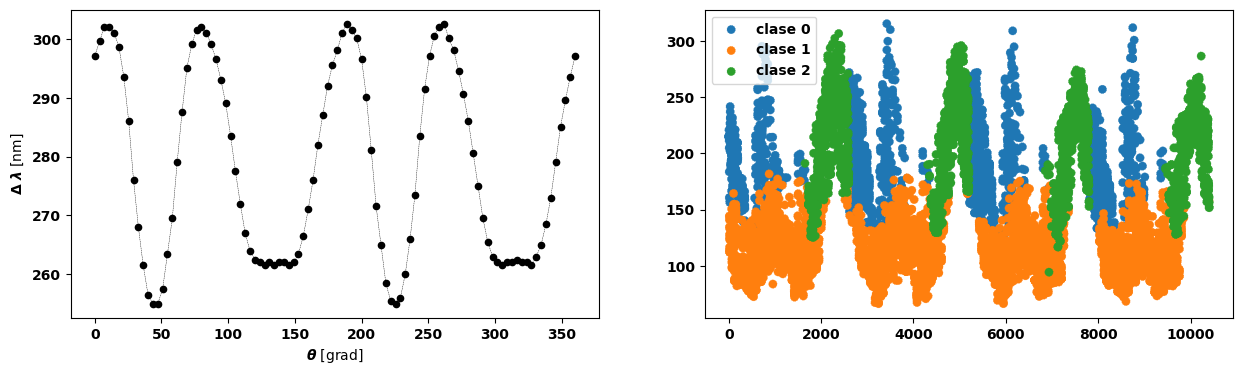

In [118]:
f = plt.figure(figsize = (15,4))

plt.subplot(121)
plt.plot(values*180/np.pi,spectral, color='black', marker='o', linestyle='dashed',linewidth=0.3, markersize=4.5)
plt.xlabel(r'$\theta$ [grad]' )
plt.ylabel('$\Delta$ $\lambda$ [nm]')

leyenda_dict = {0: 'clase 0', 1: 'clase 1', 2: 'clase 2'}
data1 = np.array(data['Ancho_espectral'])
data2 = np.array(data['Clases'])

# Crear una figura y ejes

plt.subplot(122)
for valor in np.unique(data2):
    indices = np.where(data2 == valor)
    print(valor)
    plt.scatter(indices, data1[indices], label=leyenda_dict[valor],marker='o',linestyle='dashed',linewidth=0.3)


plt.legend()
plt.show()

# Prueba pulsos amplificados lab

In [3]:
paths_amps=[]
for i in range(0,38):
    for j in range(0,50):
        paths_amps.append('MUESTRA_'+str(0)+'_'+str(i)+'_'+str(j)+'.csv')
del paths_amps[0]; del paths_amps[0]
 
 

In [17]:
pulse=np.random.choice(paths_amps)
df_S1= pd.read_csv(path+'/Pulsos_amp'+'/'+pulse,skiprows=27)
power_S1=np.array(df_S1['1749.9'][:])
WL_S1=np.array(df_S1['Stop'][:])  #Wavelenght

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='k', max=1.0, readout_format…

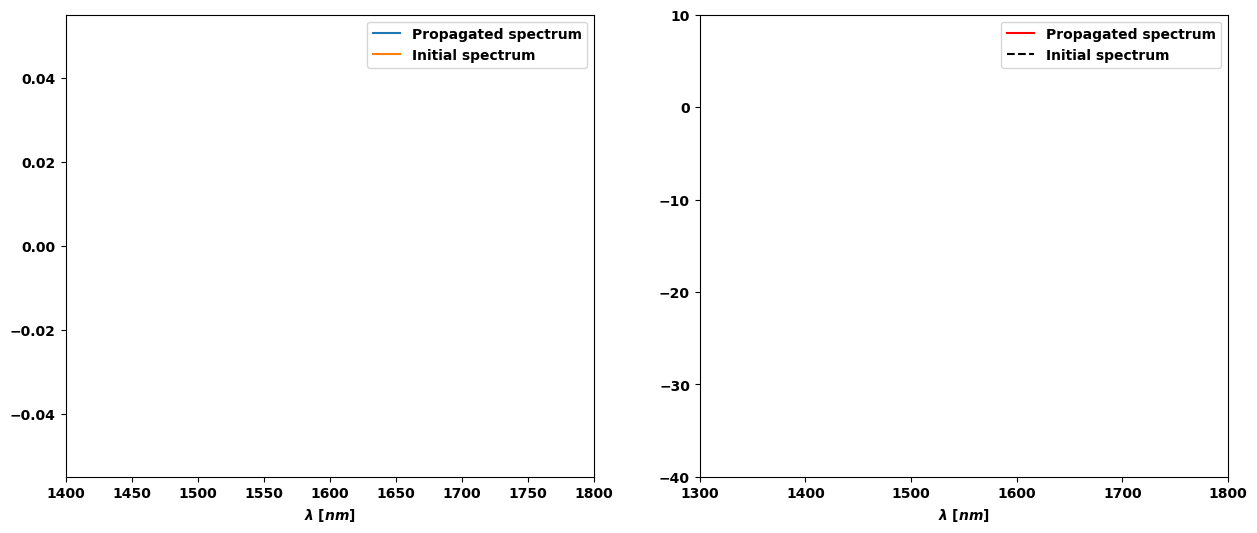

In [24]:
def anim2(k,t,BB,cons):
    
    c = 299792458
    n = len(WL_S1)   # number of grid points
    V=np.sort(2*np.pi*c/(1e-9*WL_S1))  #Frequencies.
    midV=(np.max(V)+np.min(V))/2
    V=V-midV# frequency grid
    dT = np.pi/V[-1]
    WL = WL_S1#iis = (WL>400 & WL<1350); % wavelength grid
    wl = 1550e-9      #reference wavelength [m]
    length = 2.0             #ibre length [m]
    D = -1e-12*1e9*1e-3 #Dispersion
    dD = 0.006*1e-12*1e9**2*1e-3  #Dispersion slope
    beta2=-wl**2/(2*np.pi*c)*D
    beta3=(wl**2/(2*np.pi*c))**2*(2*D/wl+dD)
    betas1=[beta2,beta3]
    betas2 = [beta2,beta3]
    gamma = 10.8*1e-3 # Coeficiente de nolinealidad fibra
    T = t*1e-15
    gammas = [gamma,gamma]
    B = [0,0]
    C = [BB,BB]
    c = 299792458;   
    S = [0,0]        
    delta = 0
    steps = 100
    A1 = (1-k)*fourierI(np.sqrt(power_S1))*cons
    A2 = k*fourierI(np.sqrt(power_S1))*cons   #np.sqrt(power)*1/np.cosh(TimeGrid/(t0/2.634)) # input field [W^(1/2)]
      
    y1,y2 = fourier_split_modc(A1,A2,V,delta,S,T,C,B,gammas,betas1,betas2,length,dT,steps)

    f = plt.figure(figsize = (15,6))
    plt.subplot(121)

    yf = fourierT(y1+y2)
    y = np.abs(yf/np.amax(yf))**2
    plt.plot(WL,y, label = 'Propagated spectrum')
    plt.plot(WL,np.abs(fourierT(A1+A2))**2/np.amax(np.abs(fourierT(A1+A2))**2), label = 'Initial spectrum')
    plt.xlim(1400,1800)
    plt.xlabel('$\lambda$ $[nm]$')
    plt.legend()

    ylog = 10*np.log10(y)
    yin = fourierT(A1+A2)/np.amax(fourierT(A1+A2))
    ylog_in = 10*np.log10(np.abs(yin)**2)
    
    plt.subplot(122)
    plt.plot(WL,ylog,'r',label ='Propagated spectrum')
    plt.plot(WL,ylog_in,'--k',label = 'Initial spectrum')
    plt.xlabel('$\lambda$ $[nm]$')
    plt.legend()
    plt.xlim(1300,1800)
    plt.ylim(-40,10)
    print(Delta_landa1(y,WL))
    print(cons)

    f = plt.figure(figsize = (15,6))
    plt.plot(A1,A2)
  
   

opc=dict(continuous_update=False,readout_format=".3f")
interact(anim2,         
        k= widgets.FloatSlider(min=0,max=1,value=0,step=0.01,**opc),
        t = widgets.FloatSlider(min=0.3,max=3,value=0.49,step=0.1,**opc),
        BB = widgets.FloatSlider(min=0,max=2,value=2/3,step=0.1,**opc),
        cons = widgets.FloatSlider(min=0,max=1,value=5,step=0.1,**opc)
     
        
        #mm
        );

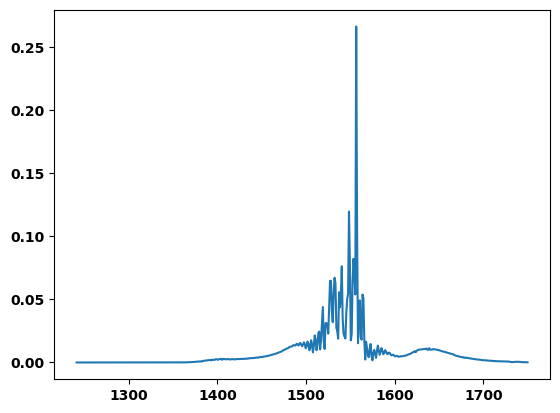

In [115]:
df_S1= pd.read_csv(path+'/conti.csv',skiprows=28)
WL = df_S1['Wavelength(A)']
power = df_S1['Level(A)']
plt.plot(WL,power)

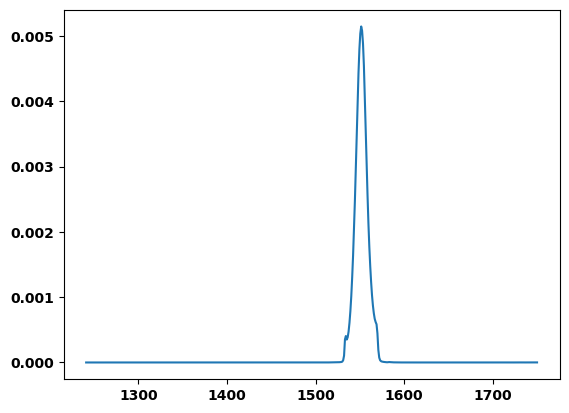

In [117]:
df_S2= pd.read_csv(path+'/conti2.csv',skiprows=28)
WL = df_S2['Wavelength(A)']
power1 = df_S2['Level(A)']
plt.plot(WL,power1)

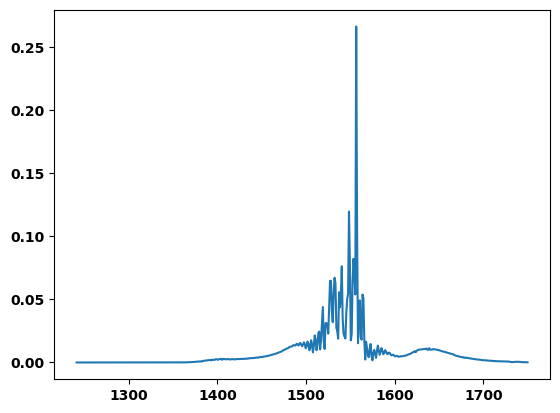

In [114]:
plt.plot(WL,power)